# Transfer Learning for Cars vs Bikes Image Classification






References
* https://machinelearningmastery.com/transfer-learning-for-deep-learning/#:~:text=Transfer%20learning%20is%20a%20machine,model%20on%20a%20second%20task.&text=Common%20examples%20of%20transfer%20learning,your%20own%20predictive%20modeling%20problems.
* https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
* https://www.tensorflow.org/tutorials/images/transfer_learning

## downloading and importing the dataset

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1aqBqYv7dvpFnX-MGxRmUFkPMj80SH5xa'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('archive.zip')

In [ ]:
import shutil
shutil.rmtree('/content/cars_and_bikes', ignore_errors=True)
!mkdir /content/cars_and_bikes
!unzip -q /content/archive.zip -d /content/cars_and_bikes

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import random
from glob import glob
from pathlib import Path
import splitfolders
DATASET_DIR = os.path.join("/content", "cars_and_bikes")

all_data = [y for x in os.walk(DATASET_DIR) for y in glob(os.path.join(x[0], '*jpg'))]
all_labels = [os.path.basename(os.path.dirname(x)) for x in all_data]
print(len(all_data))
all_data[:10]

file_path = os.path.join(DATASET_DIR, "Car-Bike-Dataset/")
splitfolders.ratio(file_path, output="./new",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)
TRAIN_DIR = './new/train'
VAL_DIR = './new/val'
TEST_DIR = './new/test'


235


Copying files: 4000 files [00:01, 2322.38 files/s]


## visualizaiton

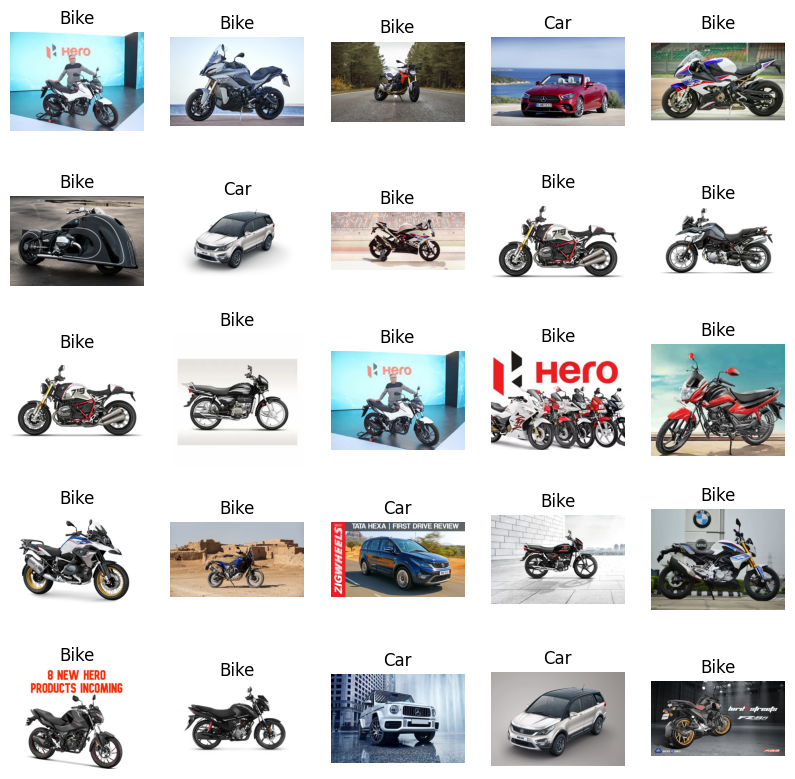

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Sample 25 images from dataset
indices = np.random.randint(0, len(all_data), size=25)
images = [all_data[i] for i in indices]
labels = [all_labels[i] for i in indices]

# Plot the 25 images
plt.figure(figsize=(10,10))
for i in range(len(indices)):
    plt.subplot(5, 5, i + 1)
    image = mpimg.imread(images[i]) # Read image from disk
    plt.imshow(image)
    plt.title(labels[i])
    plt.axis('off')

plt.show()

## Load Images

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

BATCH_SIZE = 64
HEIGHT = 200
WIDTH = 200

# 1. Construct an instance of the `ImageDataGenerator` class
train_datagen =  ImageDataGenerator(
      preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
      width_shift_range=0.1,
      height_shift_range=0.1,
      rotation_range=20
    )

# 2. Retrieve the iterator
train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 3200 images belonging to 2 classes.


In [ ]:
val_generator = train_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    shuffle = True,
    seed = 7,
    color_mode='rgb',
    class_mode='categorical')

Found 400 images belonging to 2 classes.


In [ ]:
# Do the same steps for the test set

# 1. Construct an instance of the `ImageDataGenerator` class
test_datagen =  ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
    )

# 2. Retrieve the iterator
test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical')

Found 400 images belonging to 2 classes.


# Model

In [ ]:
from keras.applications.resnet import ResNet50
#from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout

# Load model without classification head
base_model = ResNet50(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

# Print base model summary
base_model.summary()

# Mark loaded layers as not trainable
for layer in base_model.layers:
  layer.trainable = False

# You can choose to fine-tune some of the final layers:
# for layer in base_model.layers[:25]:
#  layer.trainable = False

# You can pick which layers are trainable and which are not:
base_model.get_layer('conv1_bn').trainable = False


# Add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(512, activation='relu')(x)

x = Dense(256, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

# Print summary
model.summary()

# Compile
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = base_learning_rate),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

# Training

In [ ]:
import tensorflow as tf

INITIAL_EPOCHS = 7

history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs = INITIAL_EPOCHS)

Epoch 1/7
20/50 [===========>..................] - ETA: 22s - loss: 0.4977 - accuracy: 0.9469

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


50/50 [==============================] - 68s 1s/step - loss: 0.2531 - accuracy: 0.9669 - val_loss: 0.1043 - val_accuracy: 0.9650
Epoch 2/7
50/50 [==============================] - 43s 857ms/step - loss: 0.0770 - accuracy: 0.9831 - val_loss: 0.0342 - val_accuracy: 0.9900
Epoch 3/7
50/50 [==============================] - 44s 878ms/step - loss: 0.0421 - accuracy: 0.9903 - val_loss: 0.0386 - val_accuracy: 0.9925
Epoch 4/7
50/50 [==============================] - 43s 871ms/step - loss: 0.0361 - accuracy: 0.9922 - val_loss: 0.0341 - val_accuracy: 0.9950
Epoch 5/7
50/50 [==============================] - 42s 828ms/step - loss: 0.0255 - accuracy: 0.9931 - val_loss: 0.0513 - val_accuracy: 0.9900
Epoch 6/7
50/50 [==============================] - 43s 865ms/step - loss: 0.0209 - accuracy: 0.9956 - val_loss: 0.0379 - val_accuracy: 0.9900
Epoch 7/7
50/50 [==============================] - 43s 850ms/step - loss: 0.0201 - accuracy: 0.9962 - val_loss: 0.0113 - val_accuracy: 0.9975


## Learning Curves



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


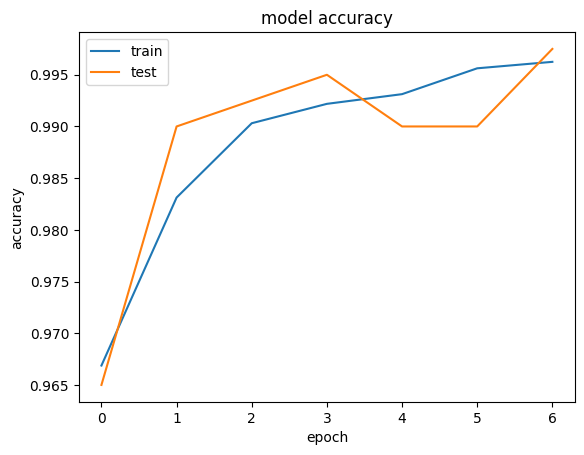

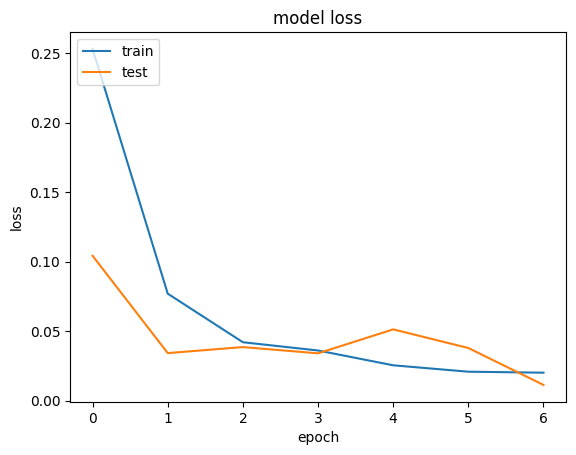

In [ ]:
# plot learning curves

print("\n")
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evaluation

In [ ]:
model.evaluate(test_generator)[1]

7/7 [==============================] - 1s 182ms/step - loss: 0.0057 - accuracy: 0.9975


0.9975000023841858

<ipython-input-15-e0ad55633f87>:38: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator)


Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

        Bike       0.45      0.45      0.45       200
         Car       0.45      0.45      0.45       200

    accuracy                           0.45       400
   macro avg       0.45      0.45      0.45       400
weighted avg       0.45      0.45      0.45       400



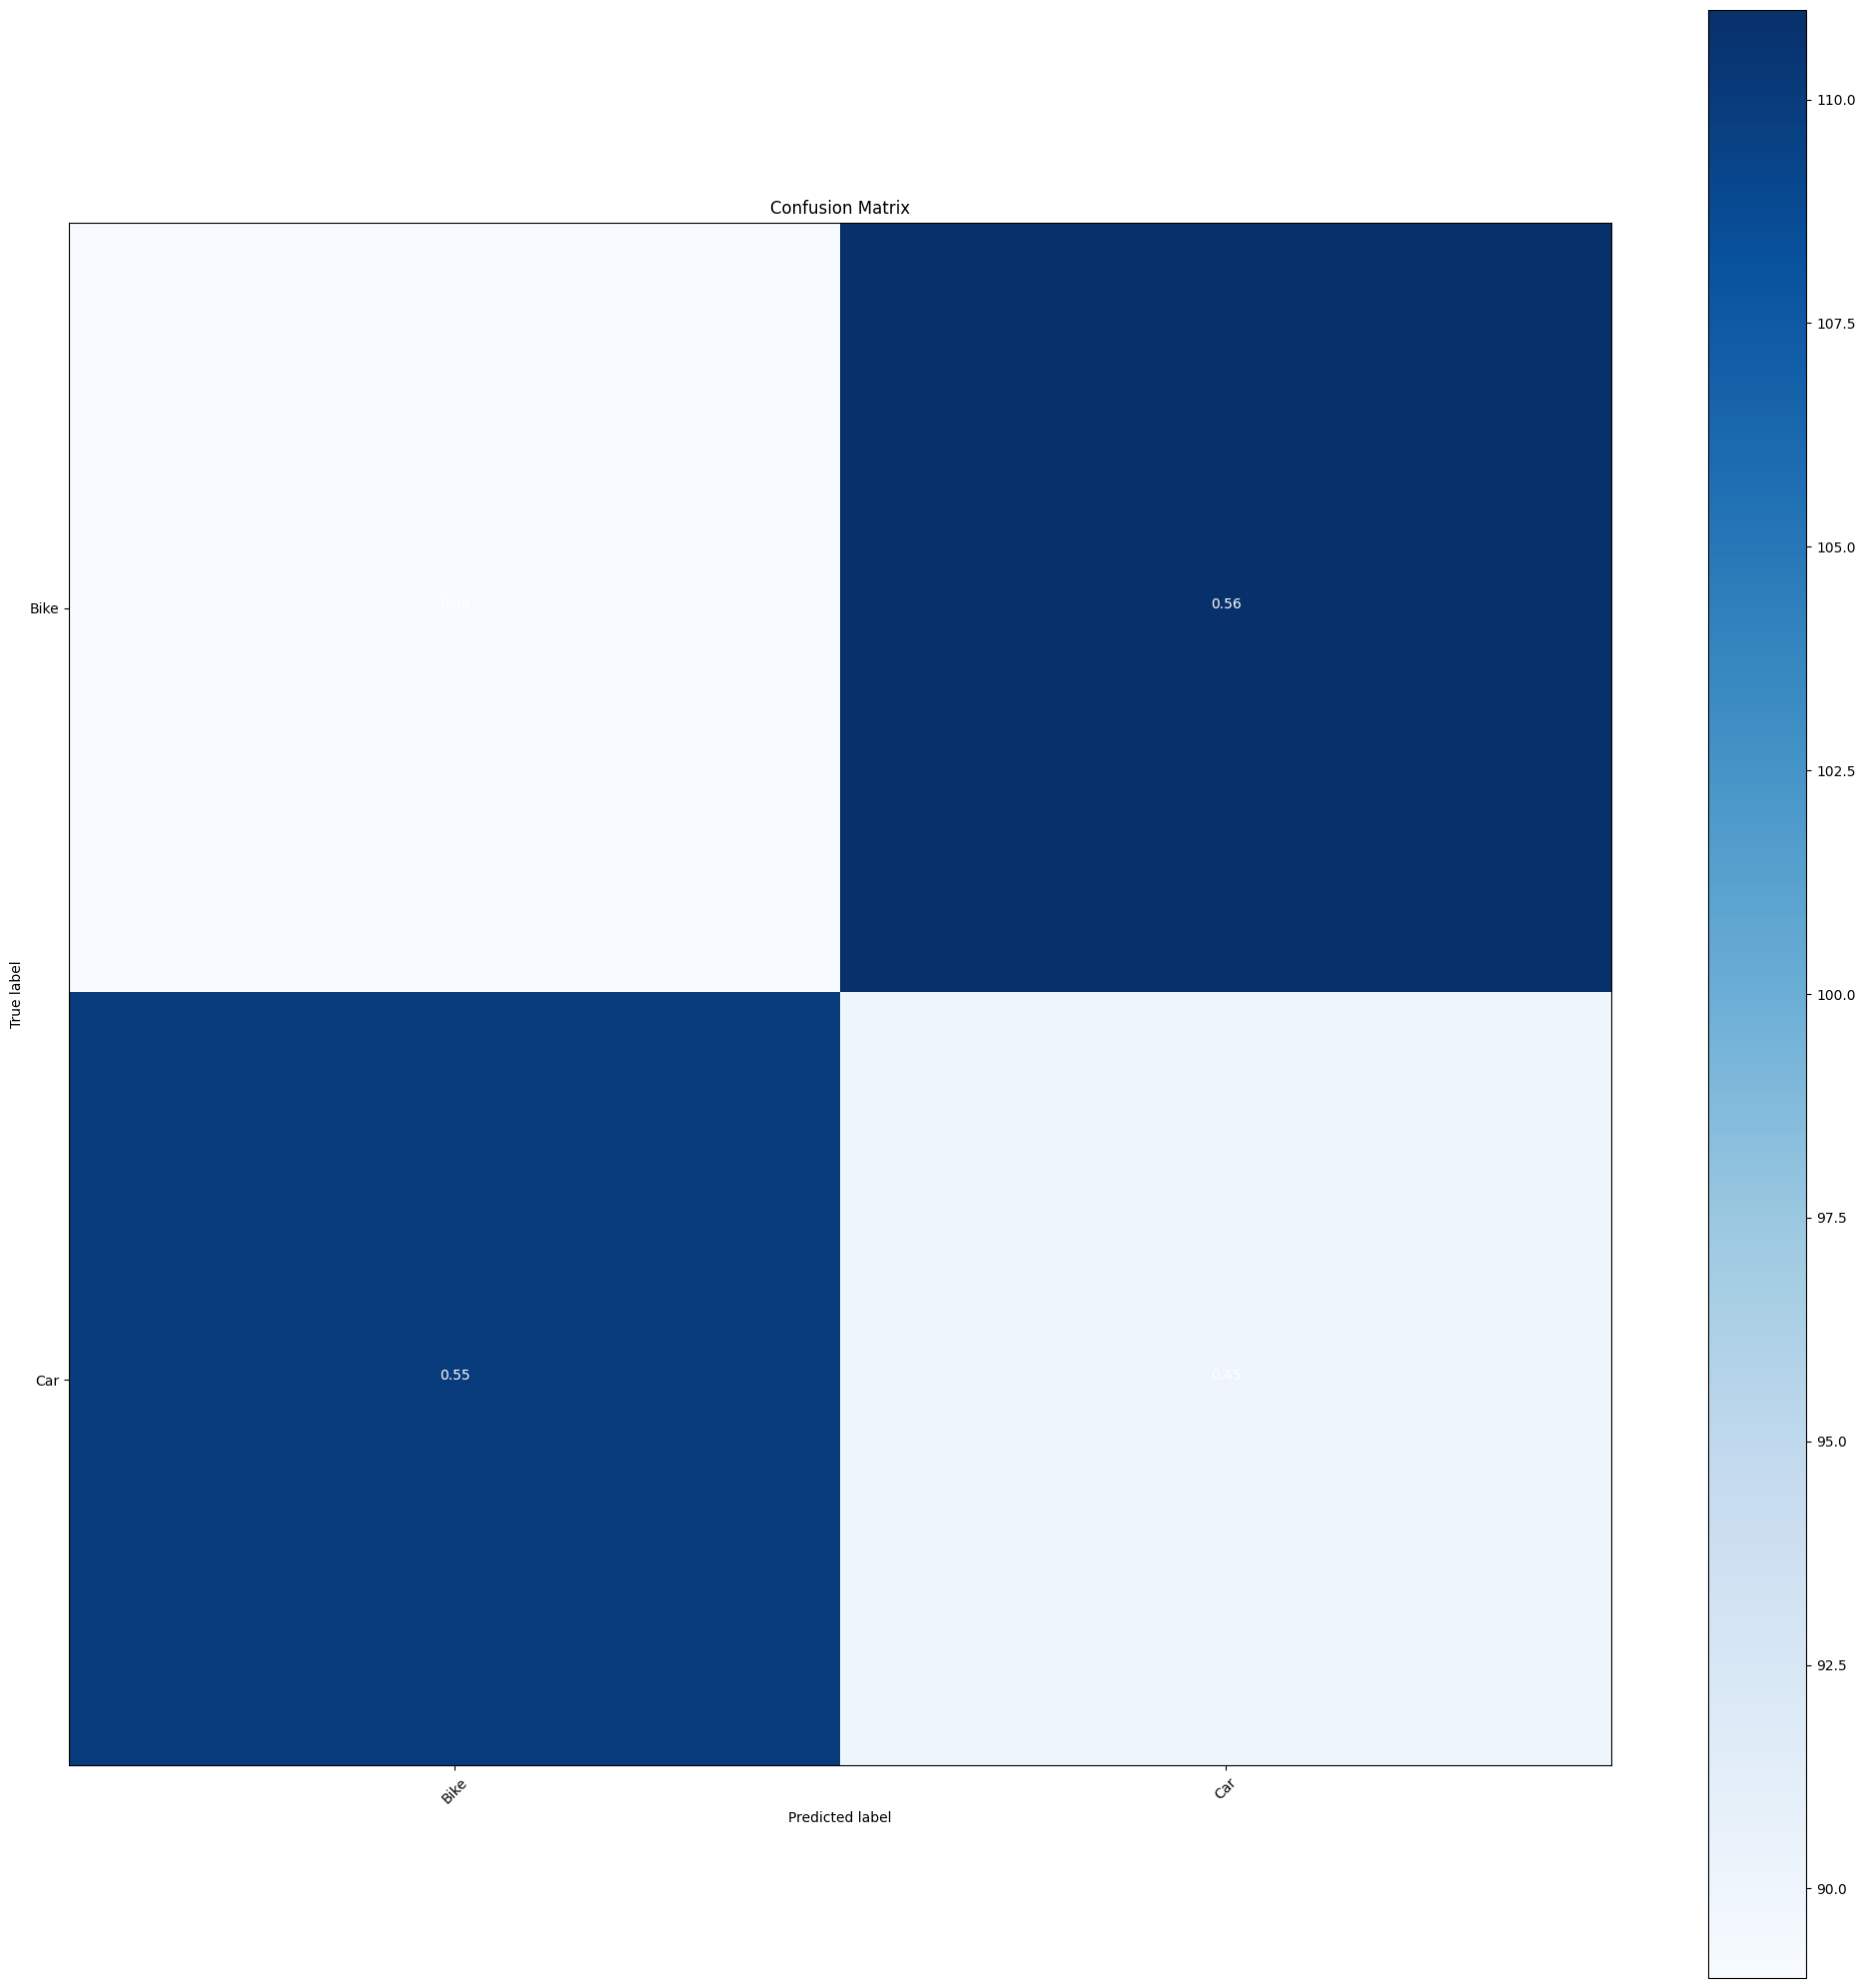

In [ ]:
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools
#shuffle=False
target_names = []
for key in train_generator.class_indices:
    target_names.append(key)
# print(target_names)
#Confution Matrix
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')
#Print Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

# using model.h5

In [ ]:
model.save('Model.h5')

In [ ]:
from keras.models import load_model
SavedModel = load_model('Model.h5')

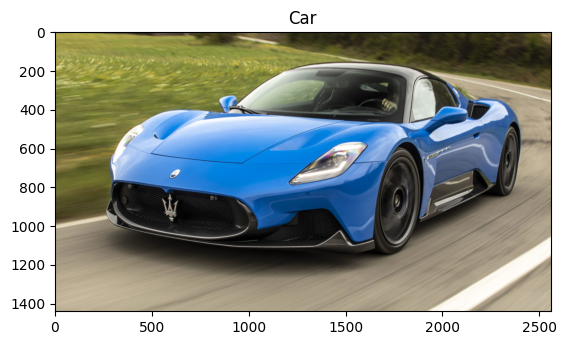

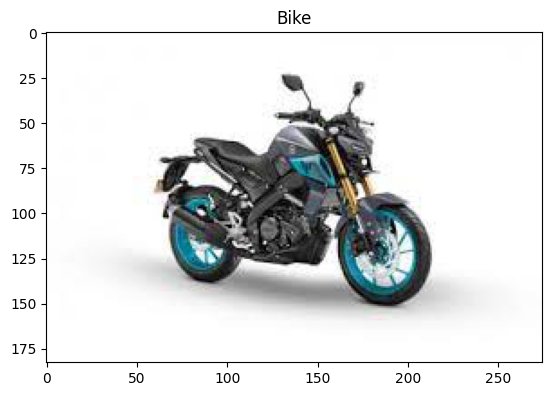

In [ ]:
import matplotlib.image as mpimg
image = mpimg.imread("/content/18015-MC20BluInfinito-scaled-e1666008987698.jpg")
plt.imshow(image)
plt.title("Car")
plt.show()
image2 = mpimg.imread("/content/download (1).jpeg")
plt.imshow(image2)
plt.title("Bike")
plt.show()